# Code for Den Rückgang der Epidemie messen

Thomas Viehmann <tv@lernapparat.de>

http://lernapparat.de/rueckgang-epidemie-messen/

Earlier English version of the same idea, but without the real data:
[The long tail of the epidemic](https://lernapparat.de/long-tail-epidemy/).

If you use this code or the idea, please cite

Thomas Viehmann, Den Rückgang der Epidemie messen, http://lernapparat.de/rueckgang-epidemie-messen/

In [1]:
import pandas
%matplotlib inline
from matplotlib import pyplot
import numpy
import datetime
import math
import matplotlib
import seaborn
seaborn.set()


In [65]:
# this uses the JHU repository https://github.com/CSSEGISandData/COVID-19/ . Thank you.
confirmed = pandas.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pandas.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = pandas.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

population = pandas.read_csv('./covid19_scenarios/data/populationData.tsv', sep='\t')
confirmed.insert(0, 'geo', [r['Country/Region'].rstrip('*') if r['Province/State'] != r['Province/State'] else (r['Country/Region']+'.'+r['Province/State']) for _, r in  confirmed.iterrows()])
confirmed.loc[confirmed['Country/Region'] == 'Korea, South', 'geo'] = 'South Korea'
confirmed.loc[confirmed['Province/State'] == 'Hong Kong', 'geo'] = 'Hong Kong'

population_d = dict(zip(population['name'], population['populationServed']))
population_d['Taiwan'] = population_d['Taiwan, Province of China']
population_d['South Korea'] = 51_600_000
population_d['New York'] = 19_453_561
population_d['California'] = 39_512_223
population_d['Vietnam'] = population_d['Viet Nam']
population_d['United Kingdom'] = 67_886_004
confirmed.iloc[:,4:].iloc[:,39:]
confirmed

# Data from RKI through https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0, thank you
df = pandas.read_csv('./RKI_COVID19.2020-04-26.csv')
df['Meldedatum'] = pandas.to_datetime(df.Meldedatum).dt.date
if 'IdLandkreis' not in df.columns:
    df['IdLandkreis'] = df.LandkreisID
if df.IdLandkreis.dtype.type != numpy.int64 :
  df['IdLandkreis'] = df['IdLandkreis'].map(lambda x: int(x.replace(' ','') if '-' not in x else -1))
df_kreise = pandas.read_csv('./deutschland_kreise.csv', index_col='key')
for k in ['population', 'male', 'female']:
    df_kreise[k] = df_kreise[k].map(lambda x: int(x.replace(' ','')))
df = df.join(df_kreise, 'IdLandkreis')
bl_cases = df.groupby(['Bundesland', 'Meldedatum'])['AnzahlFall'].sum()
bl_pop = df.groupby('IdLandkreis')[['Bundesland','population']].first().groupby('Bundesland')['population'].sum()
de_total = int(df.groupby('IdLandkreis')[['population']].first().sum())
de_cases = df.groupby(['Meldedatum'])['AnzahlFall'].sum()

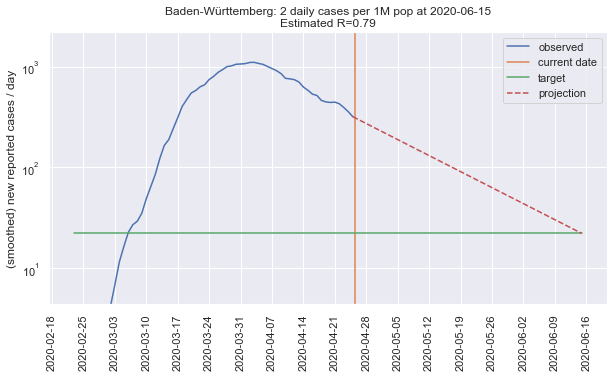

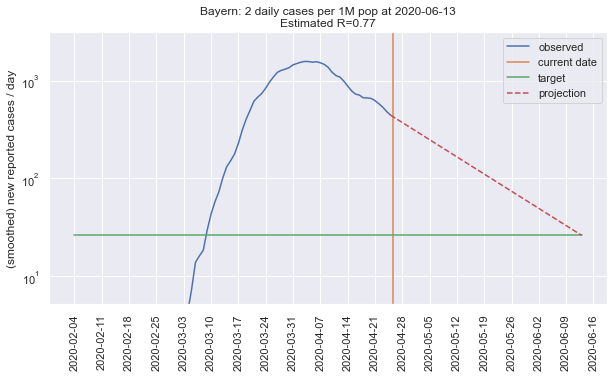

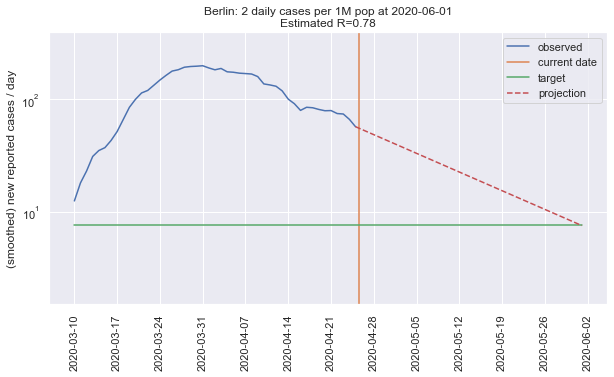

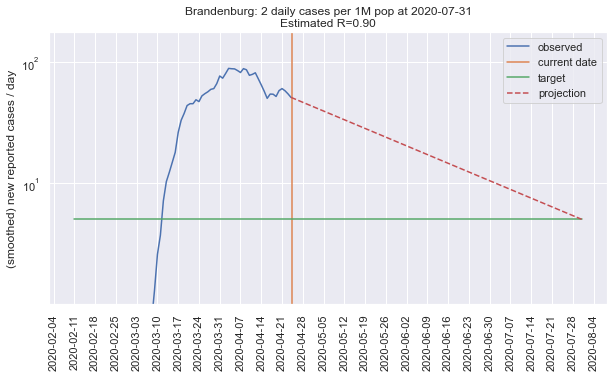

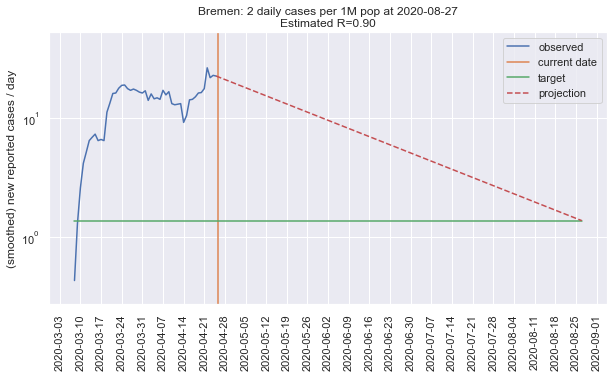

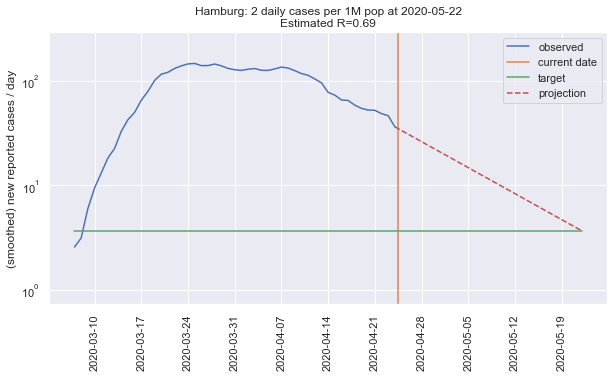

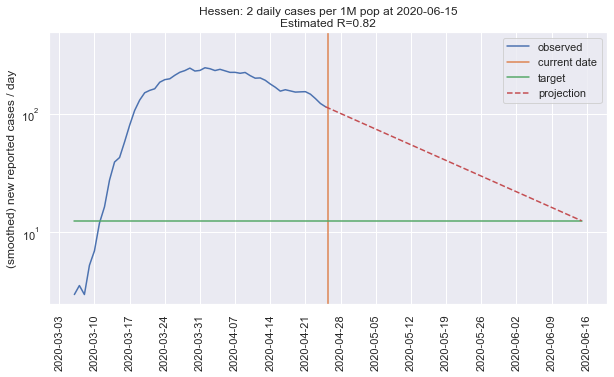

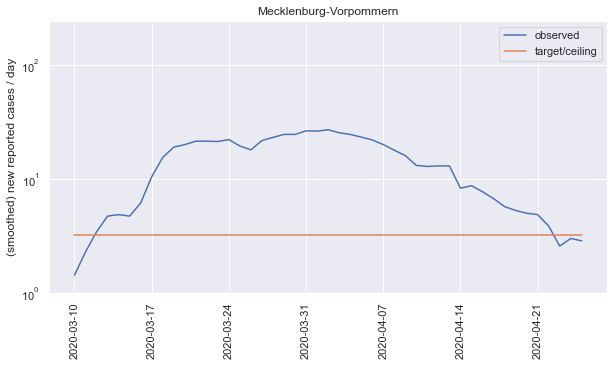

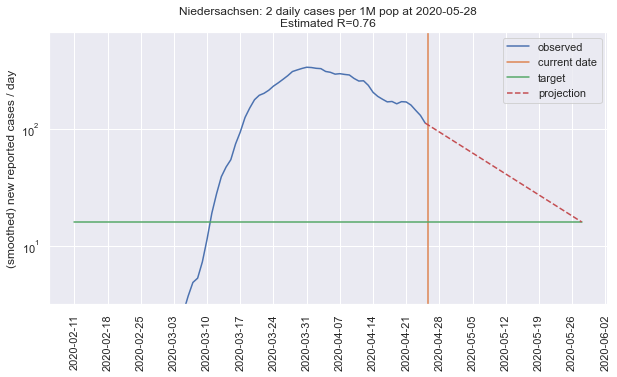

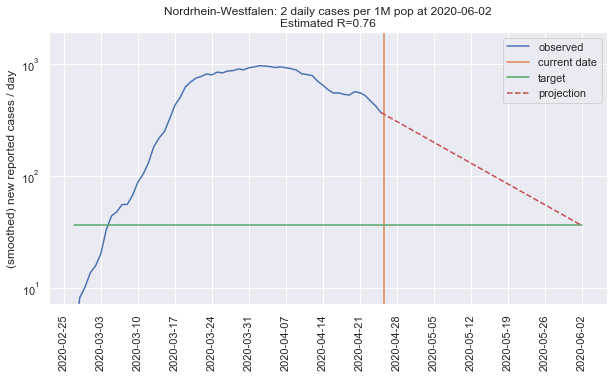

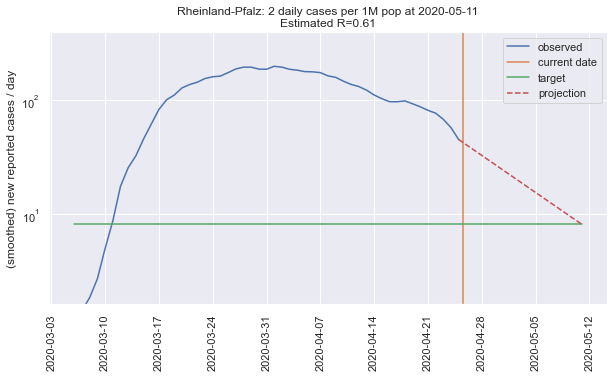

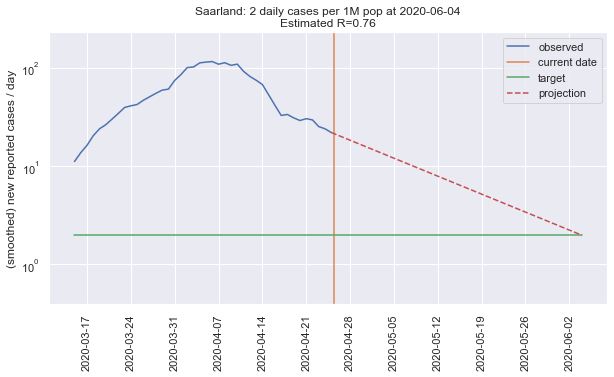

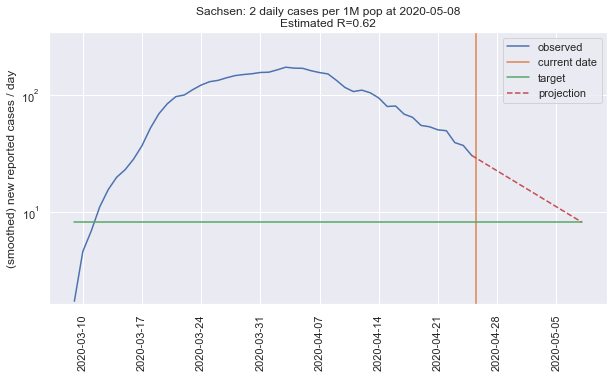

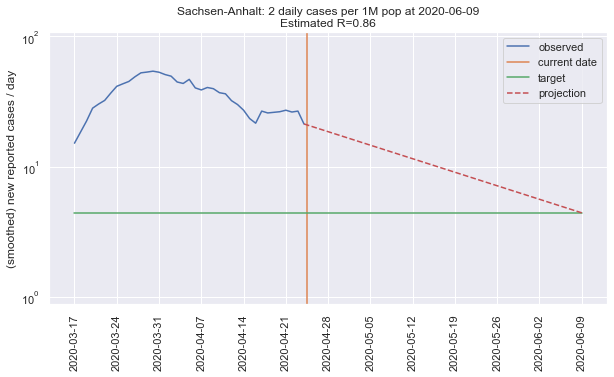

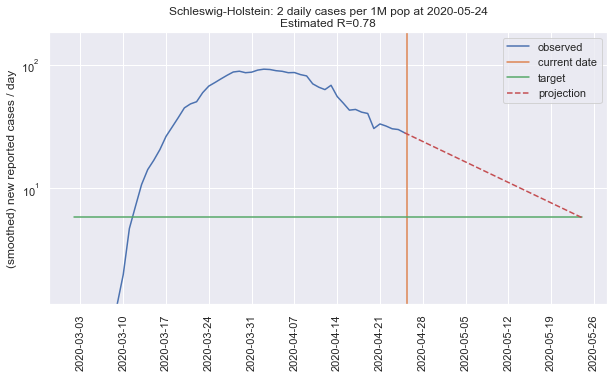

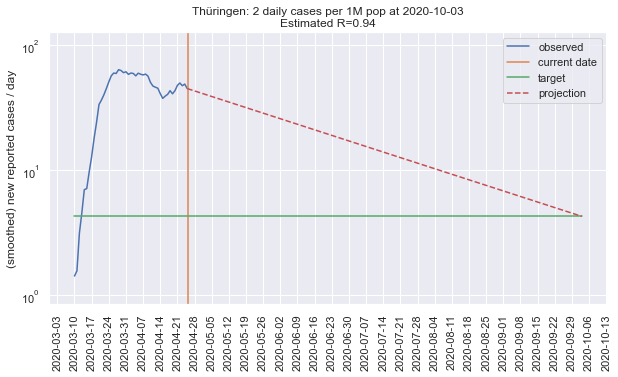

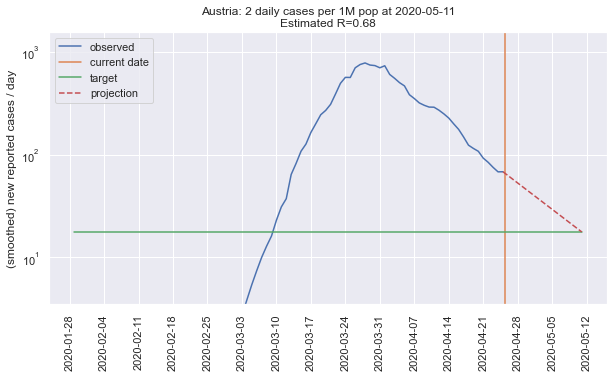

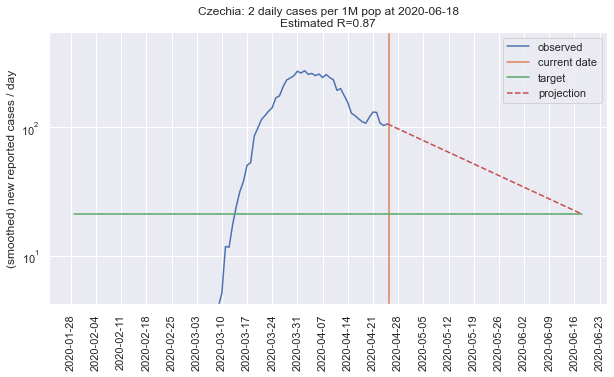

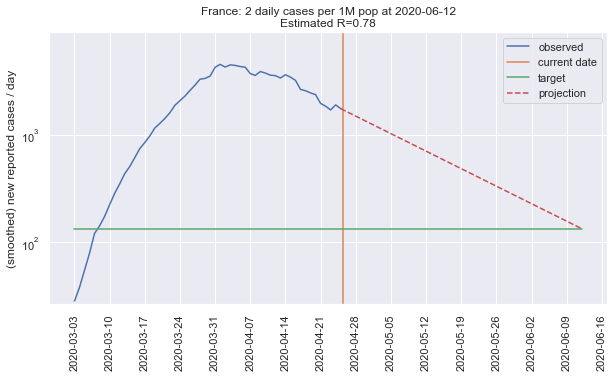

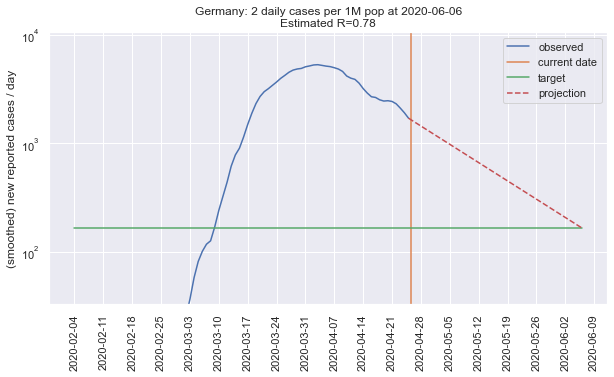

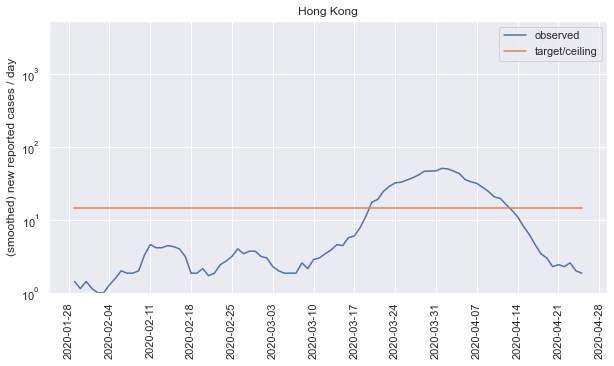

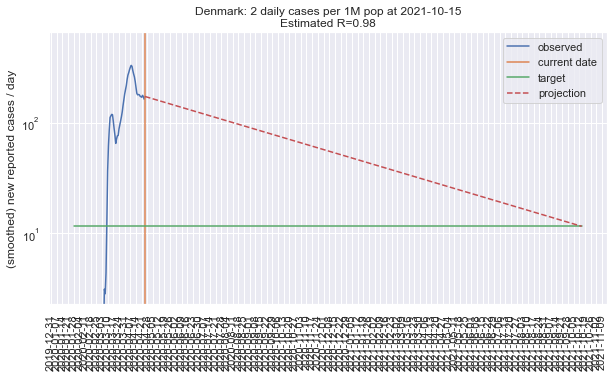

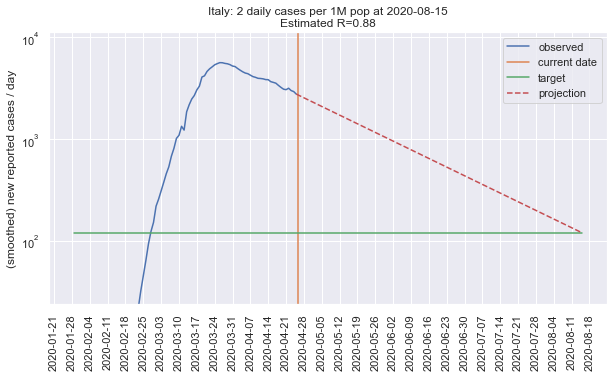

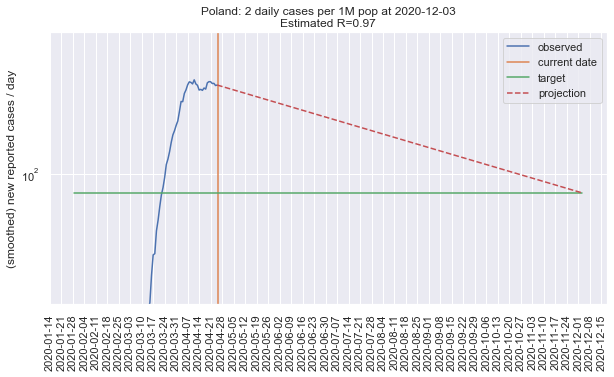

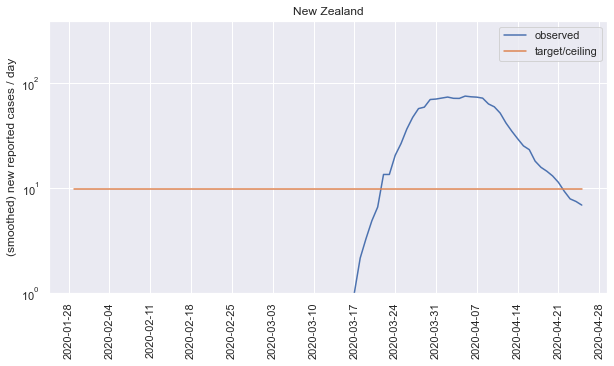

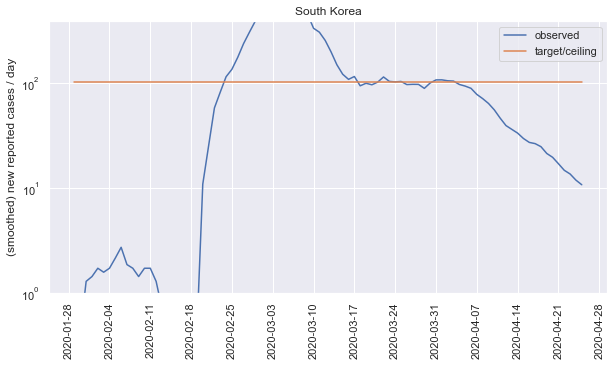

<ipython-input-66-25cbb84d7674>:60: RuntimeWarning: divide by zero encountered in double_scalars
  time_to_reach = numpy.log(traceable_cases/diffs[-1])/numpy.log(reduction_factor_per_day)+0.999


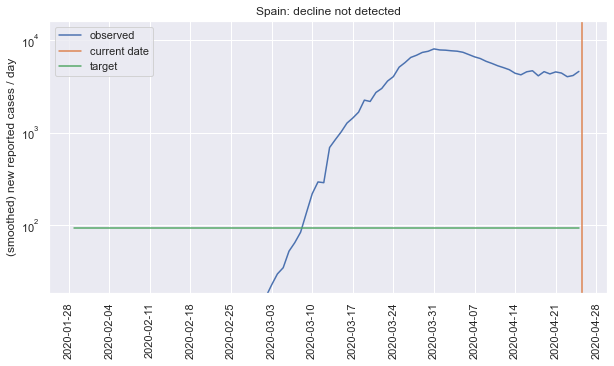

<ipython-input-66-25cbb84d7674>:60: RuntimeWarning: divide by zero encountered in double_scalars
  time_to_reach = numpy.log(traceable_cases/diffs[-1])/numpy.log(reduction_factor_per_day)+0.999


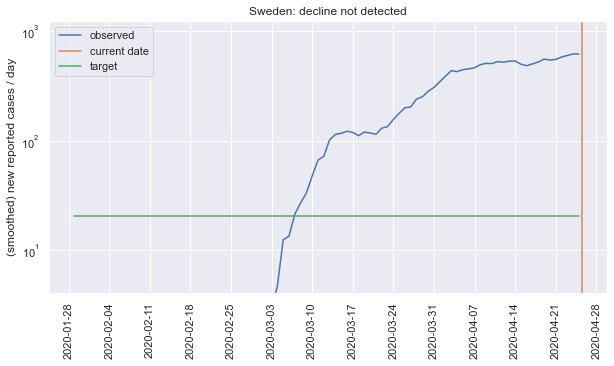

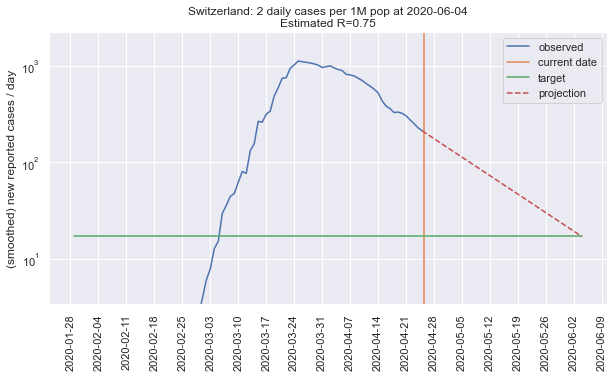

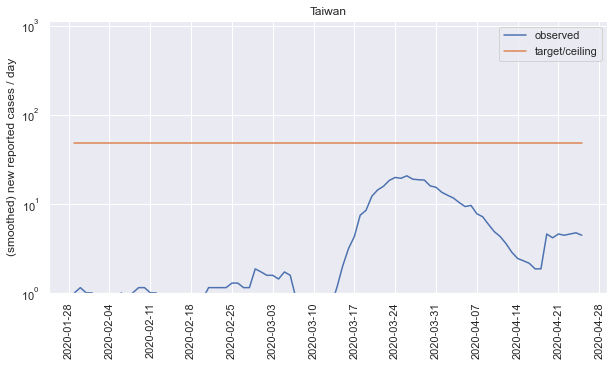

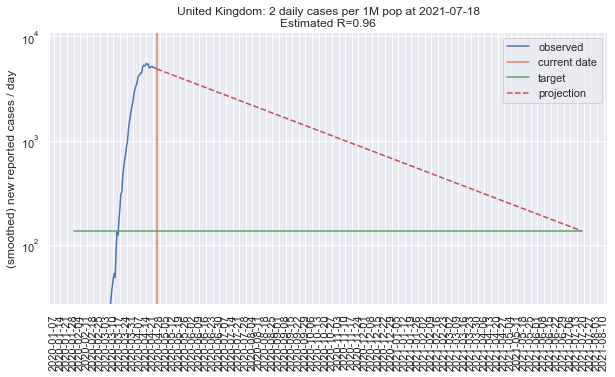

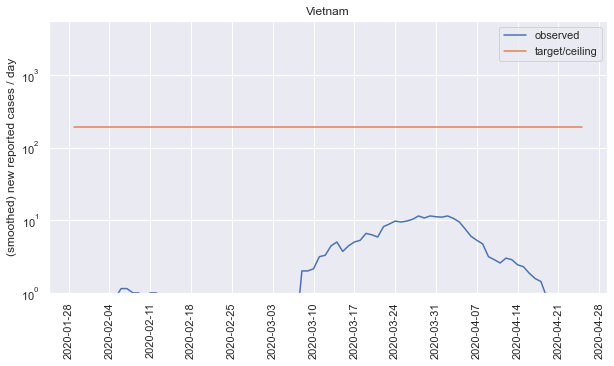

In [66]:
geos = list(bl_pop.keys()) + [
    
    'Austria',
    'Czechia',
    'France',
    'Germany',
    'Hong Kong',
    'Denmark',
    'Italy',
    'Poland',
    'New Zealand',
    'South Korea',
    'Spain',
    'Sweden',
    'Switzerland',
    'Taiwan',
    'United Kingdom',
    'Vietnam',
]

#geos = [   'Germany']

for g in geos:
    fig, ax = pyplot.subplots(figsize=(10,5))
    if g in bl_cases:
        ser = bl_cases[g]
        idx = pandas.date_range(ser.index[0], ser.index[-1])
        ser = ser.reindex(idx).fillna(0)
        traceable_cases = bl_pop[g]/1e6*2
        cumul = numpy.cumsum(ser.values)
    elif g == 'Germany':
        ser = de_cases
        idx = pandas.date_range(ser.index[0], ser.index[-1])
        ser = ser.reindex(idx).fillna(0)
        traceable_cases = de_total/1e6*2
        cumul = numpy.cumsum(ser.values)
    else:
        if g == 'Australia':
            ser = confirmed[confirmed.geo.str.startswith(g)].iloc[:, 5:].sum()
        elif g != 'France':
            ser = confirmed[confirmed.geo==g].iloc[0, 5:]
        else:
            fr = pandas.read_csv('./france_from_wiki.csv', sep=';', header=None, index_col=0)
            fr.index = pandas.to_datetime(fr.index)
            ser = fr[3]
        traceable_cases = population_d[g]/1e6*2
        cumul = ser.values
    averaging_interval_1 = 7
    averaging_interval_2 = 7
    start_date = pandas.to_datetime(ser.index[averaging_interval_1]).date()
    start = start_date.toordinal()

    diffs = (cumul[averaging_interval_1:]-cumul[:-averaging_interval_1])/averaging_interval_1
    pyplot.plot(numpy.arange(start, start+len(diffs)), diffs, label='observed')
    pyplot.yscale('log')

    if diffs[-1] >  traceable_cases:
        cummax = numpy.maximum.accumulate(diffs[::-1])[::-1]
        reduction_factor_per_day = (cummax[-1]/cummax[-1-averaging_interval_2])**(1/averaging_interval_2)
        time_to_reach = numpy.log(traceable_cases/diffs[-1])/numpy.log(reduction_factor_per_day)+0.999
        if not numpy.isfinite(time_to_reach):
            time_to_reach = 0
        else:
            time_to_reach = int(time_to_reach)
        date_reach = datetime.datetime.fromordinal(start+len(diffs)-1+time_to_reach)
        pyplot.plot([start+len(diffs)-0.5, start+len(diffs)-0.5], [cummax[0]*2, 0.001], label='current date')
        pyplot.ylim(traceable_cases/5,cummax[0]*2)
        pyplot.plot([start+0, start+len(diffs)-1+time_to_reach], [traceable_cases, traceable_cases], label='target')
        if time_to_reach != 0:
            pyplot.plot([start+len(diffs)-1, start+len(diffs)-1+time_to_reach], [cummax[-1], traceable_cases], '--', label='projection')
            pyplot.title(f"{g}: 2 daily cases per 1M pop at {date_reach.year:4d}-{date_reach.month:02d}-{date_reach.day:02d}\nEstimated R={reduction_factor_per_day**4.5:.2f}")
        else:
            pyplot.title(f"{g}: decline not detected")
        totallen = len(diffs)+time_to_reach
    else:
        pyplot.plot([start, start+len(diffs)-1], [traceable_cases, traceable_cases], label='target/ceiling')
        totallen = len(diffs)
        pyplot.title(g)
        pyplot.ylim(1,cummax[0])

    pyplot.ylabel('(smoothed) new reported cases / day')
    end_date = start_date + datetime.timedelta(days=totallen - 1)
    delta = datetime.timedelta(days=1)
    dates = matplotlib.dates.drange(start_date, end_date, delta)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    pyplot.xticks(rotation=90)
    datetime.datetime.fromordinal(start+len(diffs))
    pyplot.legend()
    pyplot.savefig('cases_and_proj_'+g.lower().replace(' ', '_')+'.png')
    pyplot.show()


Here is Helmholz HZI for R estimates: https://gitlab.com/simm/covid19/secir/-/wikis/Report

Some additional graphs for the blog post:

In [382]:
de_cases = df.groupby(['Meldedatum'])['AnzahlFall'].sum()
de_total = df.groupby('IdLandkreis')[['population']].first().sum()

In [567]:
de_total, population_d['Germany']

(population    83128825
 dtype: int64,
 82927922)

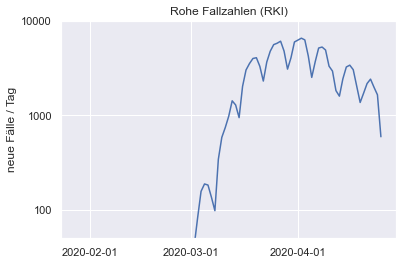

In [596]:
fig, ax = pyplot.subplots()
pyplot.plot(de_cases)
pyplot.yscale('log')
ax.yaxis.set_major_formatter(pyplot.ScalarFormatter())
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
pyplot.ylim(50,10000)
pyplot.title('Rohe Fallzahlen (RKI)')
pyplot.ylabel('neue Fälle / Tag')
pyplot.savefig('fallzahlen_roh.png')

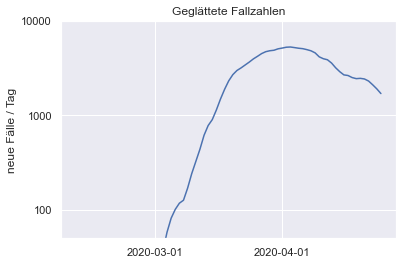

In [595]:
fig, ax = pyplot.subplots()
cumul = de_cases.cumsum()
pyplot.plot((cumul[7:]-cumul.values[:-7])/7)
pyplot.yscale('log')
ax.yaxis.set_major_formatter(pyplot.ScalarFormatter())
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
pyplot.ylim(50,10000)
pyplot.title('Geglättete Fallzahlen')
pyplot.ylabel('neue Fälle / Tag')
pyplot.savefig('fallzahlen_geglaettet.png')